# Final Project: Performance in the NBA

### Shankara Srikantan, Mohak Buch, Adiyan Kaul

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import cufflinks as cf
cf.set_config_file(offline=True, sharing=False, theme='ggplot');
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



## Source and Clean Data

In [6]:
'''All files are stored in local drive folder.'''
college = pd.read_csv("college.csv")

team_box_scores = pd.read_csv("Basketball-TeamBoxScores.csv")
player_box_scores = pd.read_csv("Basketball-PlayerBoxScore.csv")
box_scores = pd.read_csv("2012-18_officialBoxScore.csv", sep = ',',header = 0)
standings = pd.read_csv("Standings.csv")
all_stars = pd.read_csv("all_star.csv")
#Source: https://www.basketball-reference.com/allstar/NBA-allstar-career-stats.html
players = pd.read_csv("players.csv")
salaries = pd.read_csv("salaries_1985to2018.csv")
#Source: https://data.world/datadavis/nba-salaries
salaries = pd.merge(players, salaries, how='right', left_on='_id', right_on='player_id')
caps = pd.read_csv("nba_salary_caps.csv")[['Season', 'Salary Cap']]
#Source: https://basketball.realgm.com/nba/info/salary_cap


Check the size of data, and the number of missing values. Our main observation is that the "college" dataset contains many null values, which we deal with in subsequent code cells. We note that most of the missing values are among NCAA statistics, with many exceptions. All are handled at the very end of this section of the codebook. 

In [7]:

print("College", college.shape, "NA: ", sum(college.isnull().sum()))
print("Box Scores", box_scores.shape, "NA: ", sum(box_scores.isnull().sum()))
print("Team Box Scores", team_box_scores.shape,"NA: ", sum(team_box_scores.isnull().sum()))
print("Player Box Scores", player_box_scores.shape, "NA: ", sum(player_box_scores.isnull().sum()))
print("Standings", standings.shape, "NA: ", sum(standings.isnull().sum()))
'''Because of how we will merge, we won't have to worry about NA values in Salaries and All Stars. '''
print(college.isnull().sum())

College (4576, 34) NA:  34298
Box Scores (44284, 119) NA:  0
Team Box Scores (14758, 123) NA:  8
Player Box Scores (155713, 51) NA:  82
Standings (29520, 39) NA:  0
Unnamed: 0             0
active_from            0
active_to              0
birth_date            29
college              302
height                 1
name                   0
position               1
url                    0
weight                 6
NBA__3ptapg         1128
NBA__3ptpct         1623
NBA__3ptpg          1128
NBA_efgpct          1150
NBA_fg%               28
NBA_fg_per_game        0
NBA_fga_per_game       0
NBA_ft%              198
NBA_ft_per_g           0
NBA_fta_p_g            0
NBA_g_played           0
NBA_ppg                0
NCAA__3ptapg        2708
NCAA__3ptpct        2850
NCAA__3ptpg         2705
NCAA_efgpct         4576
NCAA_fgapg          1994
NCAA_fgpct          1993
NCAA_fgpg           1978
NCAA_ft             1982
NCAA_ftapg          1984
NCAA_ftpg           1978
NCAA_games          1978
NCAA_ppg  

We will make sure that all data is post-1990, since the basketball of the 80s is hardly comparable to today's game.

In [8]:
college = college[college["active_from"] >= 1990]
'''The salaries conversion here is for visualization purposes. Left joining with the college dataset
will also result in the desired years being included. '''
salaries = salaries[salaries['season_start'] > 1990]

We are interested in seeing how NBA salaries have changed over time, so that we can come up with a method to eliminate salary inflation from affecting our analysis.

LinregressResult(slope=161677.97041591848, intercept=-320613293.14270234, rvalue=0.2889205107700325, pvalue=2.4669897996602507e-240, stderr=4777.579142297659)


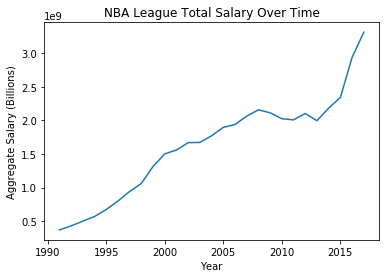

In [9]:
from scipy.stats import linregress
plt.plot(salaries.groupby('season_start').agg('sum').index,salaries.groupby('season_start').agg('sum')['salary'])
plt.xlabel('Year')
plt.ylabel('Aggregate Salary (Billions)')
plt.title('NBA League Total Salary Over Time')
print(linregress(salaries['season_start'], salaries['salary']))

To account for inflation, we will look at salary as a proportion of the salary cap rather than the dollar value. This will allow us to use historical data.

In [10]:
'''To account for inflation, we will look at salary as a proportion of the salary cap rather than
the dollar value. This will allow us to use historical data. '''
salaries['season_start'] = salaries['season_start'].apply(lambda x: str(x))
caps['season_start'] = caps['Season'].apply(lambda x: x.split('-')[0])
salaries = salaries.merge(caps, how='left', on='season_start')
salaries['SC_Ave_Prop'] = salaries['salary']/salaries['Salary Cap']
average_salary_prop = salaries.groupby('name').agg(np.mean)[['SC_Ave_Prop']]
college = college.merge(average_salary_prop, how='inner', on='name')

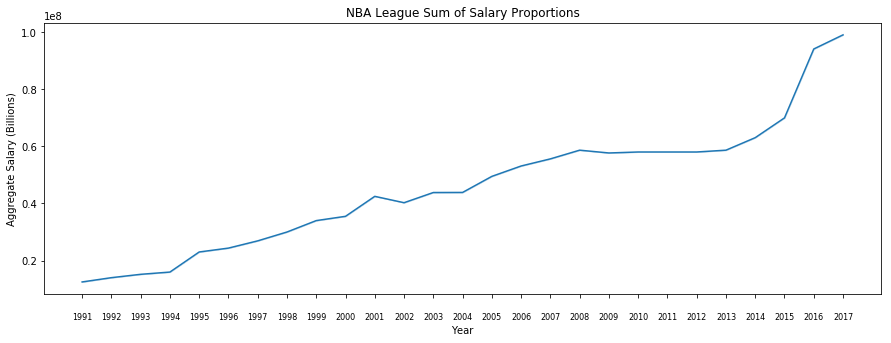

In [11]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(salaries['season_start'], salaries['Salary Cap'])
plt.xlabel('Year')
plt.ylabel('Aggregate Salary (Billions)')
plt.title('NBA League Sum of Salary Proportions')
ax.tick_params(axis='x', which='major', pad=15, labelsize=8)

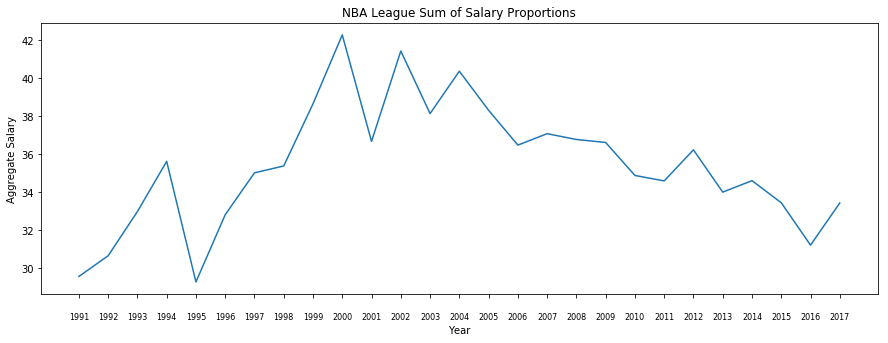

In [12]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(salaries.groupby('season_start').agg('sum').index,salaries.groupby('season_start').agg('sum')['SC_Ave_Prop'])
plt.xlabel('Year')
plt.ylabel('Aggregate Salary')
plt.title('NBA League Sum of Salary Proportions')
ax.tick_params(axis='x', which='major', pad=15, labelsize=8)

There is some season to season fluctuation here, as well as a general trend of salary increase between 1990 and 2000, and decline thereafter. Teams can, due to a number of exceptions, sign players to a total amount exceeding the salary cap. The NBA also expands the salary cap each year, so the pressure on the cap may increase and decrease based on league conditions and contract specifications

We also merge the All Star data set with the College dataset. 

In [13]:
all_stars = all_stars[["Player", "G"]].rename(columns = {"Player": "name"})
#unsure if we want to just take all the pre-2000 ones out, since we are limiting sample size
college["college"] = college["college"].fillna("International")
college_with_as = pd.merge(college,all_stars, on = "name", how = "left")
college_with_as["All_Star"] = college_with_as["G"].apply(lambda x : 1 if (x >=0) else 0)
college = college_with_as.sort_values("All_Star", ascending = False)
college = college[college['college'] != 'International'][college['NCAA_games'].notna()]
college = college.fillna(0)
def get_inches(x):
    ft, inches = x.split('-')
    return int(ft)*12 + int(inches)
college = college[college["active_from"] > 2003]
college["height"] = college["height"].apply(lambda x: get_inches(x))
college=college.drop(columns=['NCAA_efgpct'])
college = college.reset_index()

#TODO #account for nuances in names (i.e Ginóbili - > Ginobili)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Finally, we handle any remaining NaN values. 

There is a set of 40 players for whom, for unclear reasons, NCAA statistics are not available, even though they did play in college. We are removing them from the analysis, and cannot find any pattern to why they contain NaN values. Since there are only 40 such players, this should not impact the analysis much.

Second, we also notice there are NaN values elsewhere in the dataset, but mostly in the NCAA and NBA 3 point % columns. Some Googling revealed a pattern of these players being centers who have never taken a three pointer in their careers. In other cases, players played very few minutes in the NBA, and did not have numbers to fill up the categories. Therefore, we set all these values to zero. Similarly, there are a few players who have not taken a free throw. We set these values to zero as well.

In [14]:
college = college[college['college'] != 'International'][college['NCAA_games'].notna()]
college = college.fillna(0)

## Exploratory Data Analysis

First, we look at some of the basic relationships between college and NBA statistics, to assess whether this is a viable direction to take our study.

' We would have loved to look at eFG% as well, but this data is not available\nfor college players. Also we should only look at stats after the 3 point line was introduced'

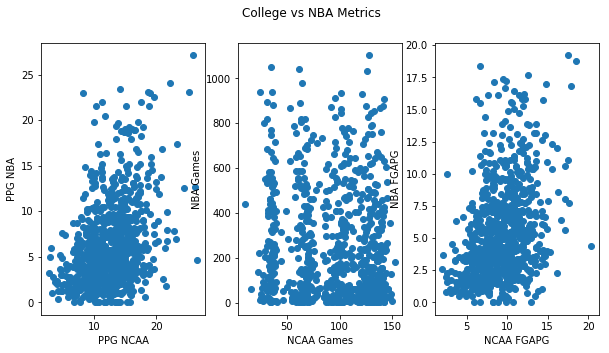

In [15]:

fig, ax = plt.subplots(ncols=3, figsize=(10,5))
fig.suptitle('College vs NBA Metrics')

ax[0].scatter(college['NCAA_ppg'], college['NBA_ppg'])
ax[0].set(xlabel='PPG NCAA')
ax[0].set(ylabel='PPG NBA')

ax[1].scatter(college['NCAA_games'], college['NBA_g_played'])
ax[1].set(xlabel='NCAA Games')
ax[1].set(ylabel='NBA Games')

ax[2].scatter(college['NCAA_fgapg'], college['NBA_fga_per_game'])
ax[2].set(xlabel='NCAA FGAPG')
ax[2].set(ylabel='NBA FGAPG')

''' We would have loved to look at eFG% as well, but this data is not available
for college players. Also we should only look at stats after the 3 point line was introduced'''



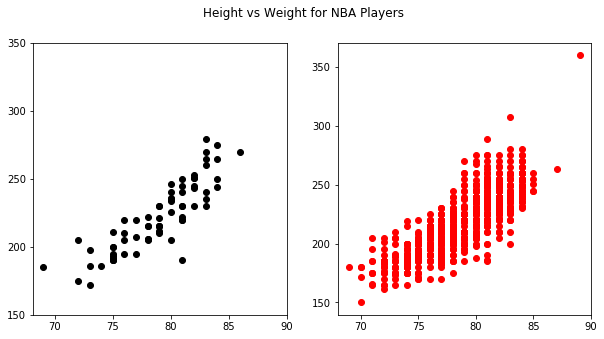

In [20]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
fig.suptitle("Height vs Weight for NBA Players")
all_star_players = college[college["All_Star"] > 0]
non_star_players = college[college["All_Star"] == 0]
ax[0].scatter(all_star_players['height'], all_star_players['weight'], color = "black")
ax[0].set_xticks([70, 75, 80, 85, 90])
ax[0].set_yticks([150, 200, 250, 300, 350])
ax[1].scatter(non_star_players["height"], non_star_players["weight"], color = "red")
#probably should split into two graphs so that the black dots don't get covered

## Linear Regression Modeling
###Predicting salary based on NCAA statistics
For our first question, about whether we can predict NBA salaries based on college statistics (effectively attempting to "value" a player), linear regression is appropriate. Specifically, we need multiple regression to weight our features and build a model that can predict a salary quantity. 

This heatmap is a reference of which variables in the college dataset are highly correlated to one another. This will inform the modeling decisions that we make. We one-hot encode "position" first. 

In [21]:
from sklearn.feature_extraction import DictVectorizer
def ohe_position(data):
    vec_enc = DictVectorizer()
    vec_enc.fit(data[['position']].to_dict(orient='records'))
    position_data = vec_enc.transform(data[['position']].to_dict(orient='records')).toarray()
    position_cats = vec_enc.get_feature_names()
    position = pd.DataFrame(position_data, columns=position_cats)
    return position
college = pd.concat([college, ohe_position(college)], axis=1)

Text(0.5,1,'Heatmap of Feature Correlations in College')

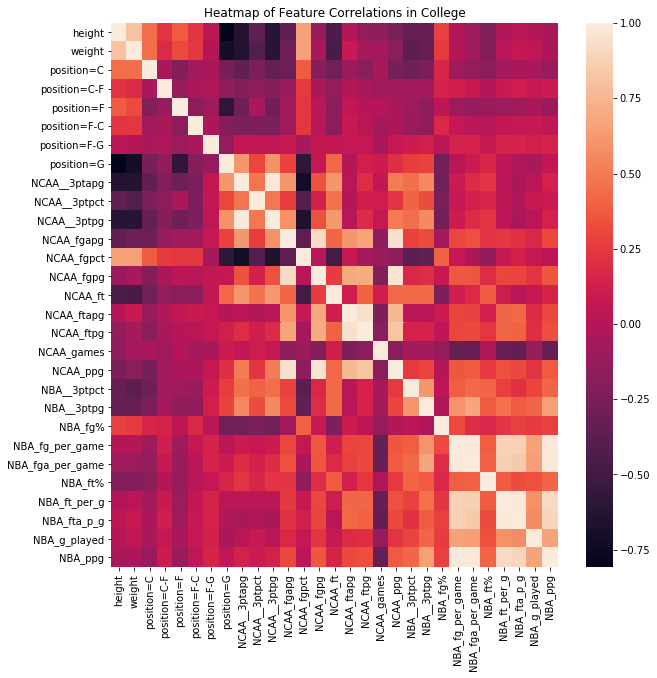

In [22]:
heat = college[['height', 'weight', "position=C", "position=C-F", "position=F", 
        "position=F-C", "position=F-G", "position=G", 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg','NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg', 
               'NBA__3ptpct', 'NBA__3ptpg', 'NBA_fg%', 'NBA_fg_per_game',
       'NBA_fga_per_game', 'NBA_ft%', 'NBA_ft_per_g', 'NBA_fta_p_g',
       'NBA_g_played', 'NBA_ppg']].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(heat, 
            xticklabels=heat.columns.values,
            yticklabels=heat.columns.values,ax=ax)
ax.set_title('Heatmap of Feature Correlations in College')


This heatmap is absolutely fascinating. It confirms some of our intuitions about basketball, and raised some new points. For instance, we see here that height and weight are both negatively correlated with three-point attempts and percentage.

Below are some functions that will help us evaluate our multiple regression models.

In [23]:
from sklearn.model_selection import KFold
from sklearn.base import clone
def cross_validate_rmse(model, X, y):
    model = clone(model)
    ten_fold = KFold(n_splits=10)
    rmse_values = []
    for tr_ind, va_ind in ten_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)
    
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual - predicted)**2))

This is the main function that will run and score our linear regression models. We pass in the columns (features) that we are interested in fitting the model with.

In [24]:
from sklearn.model_selection import train_test_split
train_college, test_college = train_test_split(college, test_size=0.25, random_state=42)

from sklearn.linear_model import LinearRegression

train_college = train_college.dropna()

def linear_regression( model, data, columns): 
    
    X = data[columns]
    Y = data[['SC_Ave_Prop']]

    model.fit(X, Y)

    Y_predicted = model.predict(X)

    data['predicted'] = Y_predicted
    data['residual'] = data['predicted'] - data['SC_Ave_Prop']

    training_error = rmse(Y_predicted, Y)
    print("RMSE: ", training_error)
    print("CV RMSE: ", cross_validate_rmse(model, X, Y))
    
    return sns.scatterplot(x='predicted', y='residual', data=data)

#### Height-Weight-Position
We will start with the most basic model: one that looks at height and weight and tries to predict salary. This is rudimentary, but we will add features later. 

RMSE:  SC_Ave_Prop    0.040028
dtype: float64
CV RMSE:  0.04012884733001284


Text(0.5,1,'Height/Weight/Position')

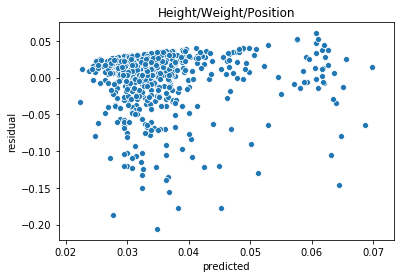

In [25]:
ax = linear_regression(LinearRegression(fit_intercept=True), train_college, ["height", "weight",  "position=C", "position=C-F", "position=F", "position=F-C", "position=F-G", "position=G"])
ax.set_title('Height/Weight/Position')

#### Key NCAA Stats

RMSE:  SC_Ave_Prop    0.036682
dtype: float64
CV RMSE:  0.036986771949935014


Text(0.5,1,'NCAA Statistics')

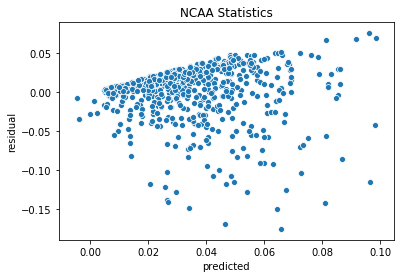

In [26]:
ax = linear_regression(LinearRegression(fit_intercept=True), train_college, ['NCAA__3ptapg', 'NCAA__3ptpct', 
                   'NCAA__3ptpg','NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
                   'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg'])
ax.set_title('NCAA Statistics')

#### NCAA Stats + Height/Weight/Position
We think this is a useful model because this contains a lot of the information a team scout would have about a college player.

RMSE:  SC_Ave_Prop    0.035927
dtype: float64
CV RMSE:  0.03689895549810236


Text(0.5,1,'NBA')

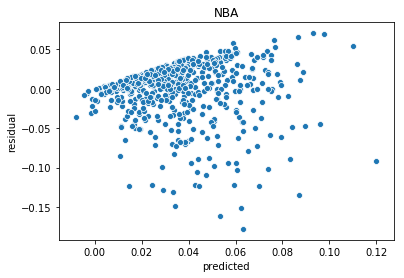

In [27]:
ax = linear_regression(LinearRegression(fit_intercept=True), train_college, ['height', 'weight', "position=C", "position=C-F", "position=F", 
        "position=F-C", "position=F-G", "position=G", 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg','NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg'])
ax.set_title('NBA')

#### Ridge Regression
Due to the possibility of multicollinearity between variables affecting our predictions, we wanted to use Ridge Regression to minimize that effect. We used NCAA and height/weight/position, since so far, that has yielded the best results. Ridge Regression results in a marginally better cross-validated score.

RMSE:  SC_Ave_Prop    0.036104
dtype: float64
CV RMSE:  0.03684534427309165


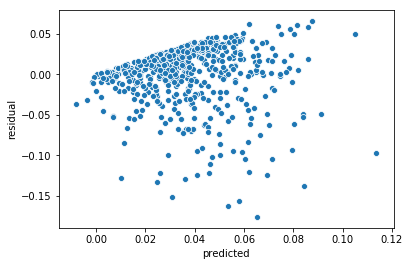

In [28]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler

'''First find the optimal alpha value. '''
scaler = StandardScaler()
X_std = scaler.fit_transform(train_college[['height', 'weight', "position=C", "position=C-F", "position=F", 
        "position=F-C", "position=F-G", "position=G", 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg','NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg']])
regr_cv = RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0])
model_cv = regr_cv.fit(X_std, train_college['SC_Ave_Prop'])
alpha = model_cv.alpha_

linear_regression(Ridge(alpha=alpha, fit_intercept=True), train_college, ['height', 'weight', "position=C", "position=C-F", "position=F", 
        "position=F-C", "position=F-G", "position=G", 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg','NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg'] )

#### NBA Stats
This is for our own curiosity. We wanted to see how well NBA statistics would predict salaries. Our prediction: quite well. 

RMSE:  SC_Ave_Prop    0.021101
dtype: float64
CV RMSE:  0.021111254313721572


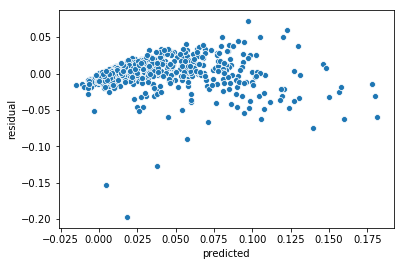

In [29]:
linear_regression(LinearRegression(fit_intercept=True), train_college, ['height', 'weight', 'NBA__3ptapg',
       'NBA__3ptpct', 'NBA__3ptpg', 'NBA_fg%', 'NBA_fg_per_game',
       'NBA_fga_per_game', 'NBA_ft%', 'NBA_ft_per_g', 'NBA_fta_p_g',
       'NBA_g_played', 'NBA_ppg', "position=C", "position=C-F", "position=F",
        "position=F-C", "position=F-G", "position=G"])

#### Test Data
Using all NCAA stats as well as height, weight, and position does improve the model. Therefore, we will use this model on the test data.

RMSE:  SC_Ave_Prop    0.039689
dtype: float64
CV RMSE:  0.03946905996105744


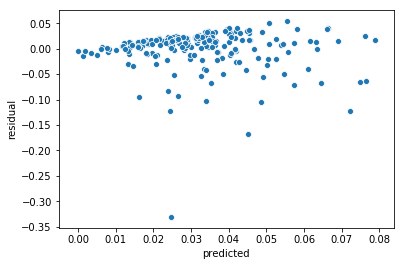

In [30]:
linear_regression(Ridge(alpha=alpha, fit_intercept=True), test_college, ['height', 'weight', "position=C", "position=C-F", "position=F", 
        "position=F-C", "position=F-G", "position=G", 'NCAA__3ptapg', 'NCAA__3ptpct',
       'NCAA__3ptpg','NCAA_fgapg', 'NCAA_fgpct', 'NCAA_fgpg',
       'NCAA_ft', 'NCAA_ftapg', 'NCAA_ftpg', 'NCAA_games', 'NCAA_ppg'])

## Logistic Regression
#### Predicting All-Stars with NCAA Data

First we frequency encode the colleges based on their prevalence in the college dataset. This is an extremely interesting method because it gives us a metric of how many NBA players colleges produce, and thereby relates to the calibre of the school. It is far more elegant than one-hot encoding for every single college.

In [31]:
''' Add a code for all colleges, in order to run logistic regression later. '''
uni_count = college.groupby("college").agg("count").sort_values("active_from", ascending = False)[["active_from"]]
uni_count = uni_count.rename(columns = {"active_from": "college_encoded"})
uni_count = uni_count.reset_index(level = "college")
uni_count["college_encoded"] = uni_count["college_encoded"]/np.sum(uni_count["college_encoded"])
college = pd.merge(college, uni_count, how = "left", left_on= "college", right_on = "college")
college["college_encoded"] = college["college_encoded"].fillna(0)
college["years active"] = college["active_to"] - college["active_from"] 
college.head()

,index,Unnamed: 0,active_from,active_to,birth_date,college,height,name,position,url,...,All_Star,position=C,position=C-F,position=F,position=F-C,position=F-G,position=G,position=G-F,college_encoded,years active
0,1650,3973,2010,2018,"June 10, 1988",Wake Forest University,74,Jeff Teague,G,/players/t/teaguje01.html,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.009592,8
1,452,1064,2013,2018,"August 10, 1993",University of Connecticut,83,Andre Drummond,C,/players/d/drumman01.html,...,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017986,5
2,125,252,2013,2018,"June 28, 1993",University of Florida,77,Bradley Beal,G,/players/b/bealbr01.html,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.019185,5
3,1480,3539,2016,2018,"February 23, 1996",Ohio State University,77,D'Angelo Russell,G,/players/r/russeda01.html,...,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.010791,2
4,773,1835,2008,2018,"June 3, 1986",University of Florida,82,Al Horford,C-F,/players/h/horfoal01.html,...,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019185,10


Text(0.5,1,'Free Throw Percentage Comparison')

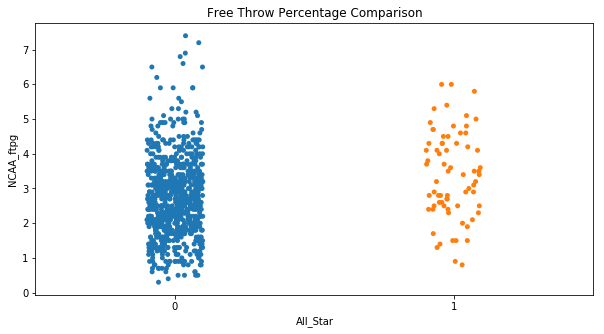

In [32]:
data = college[["height", "weight",	"NCAA__3ptapg",	"NCAA__3ptpct",	"NCAA__3ptpg",	"NCAA_fgapg",	"NCAA_fgpct",	"NCAA_fgpg",	"NCAA_ft",	"NCAA_ftapg",	"NCAA_ftpg",	"NCAA_games",	"NCAA_ppg","college_encoded"]]
target = college[["All_Star"]]
feature_names = data.columns
target_names = target.columns
plt.figure(figsize=([10, 5]))
ax = sns.stripplot(college["All_Star"], college["NCAA_ftpg"], jitter=0.10)
plt.title('Free Throw Percentage Comparison')

### *PCA*

We found that the first 3 principal components account for nearly all the variance.

Text(0,0.5,'Fraction of Variance')

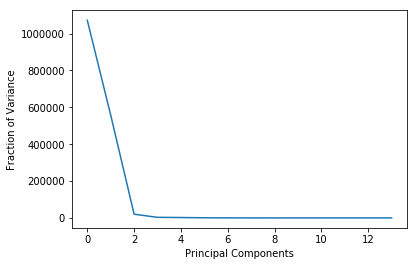

In [35]:

data = np.array(data)
target = np.array(target)
data_mean = np.mean(data, axis =0)
centered_data = data - data_mean
centered_data = data - data_mean
u, s, vt = np.linalg.svd(centered_data, full_matrices = False)
plt.plot(s**2)
plt.xlabel("Principal Components")
plt.ylabel("Fraction of Variance")
#scree plot

[0.65 0.34 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


Text(0,0.5,'pc1')

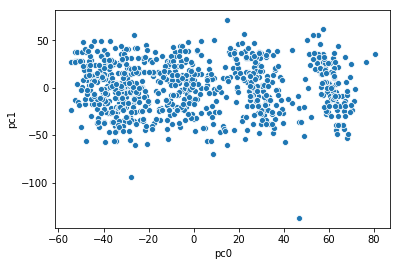

In [36]:
print(np.round(s**2 / sum(s**2), 2))
pcs = u * s
sns.scatterplot(x=pcs[:, 0], y=pcs[:, 1]);
plt.xlabel("pc0")
plt.ylabel("pc1")

#### The Model
After identifying the key features, we split our data into a training and testing set (0.75:0.25) and fit our training data to 3 classification models.
The 3 models were Logistic Regression, Decision Tree, and Random Forest.

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import tree


train_college, test_college = train_test_split(college, test_size=0.25, random_state=42)


from sklearn.linear_model import LogisticRegression

X = train_college[["height","weight", "NCAA__3ptpct",	'NCAA__3ptapg',"NCAA_fgapg",	"NCAA_fgpct",	"NCAA_ppg","college_encoded"]]
Y = train_college[["All_Star"]]

X_test = test_college[["height","weight","NCAA__3ptpct",'NCAA__3ptapg',	"NCAA_fgapg",	"NCAA_fgpct",	"NCAA_ppg","college_encoded"]]
Y_test = test_college[["All_Star"]]



depth = []
for i in range(3,20):
    clf = tree.DecisionTreeClassifier(max_depth=i)
    # Perform 7-fold cross validation 
    scores = cross_val_score(estimator=clf, X=X, y=Y, cv=7, n_jobs=4)
    depth.append((i,scores.mean()))
print(depth)



[(3, 0.9088939150736903), (4, 0.9009395722878867), (5, 0.8992983608152147), (6, 0.8961598326766865), (7, 0.8881511746680285), (8, 0.878627770481703), (9, 0.8642699061238387), (10, 0.8658028924882857), (11, 0.8609870778410105), (12, 0.8513736887332392), (13, 0.8529427501337613), (14, 0.8449880020104741), (15, 0.84655746874848), (16, 0.8448797769022488), (17, 0.8401539471764191), (18, 0.8353920424145143), (19, 0.8433646253870973)]


In [38]:

random_forest_model = ensemble.RandomForestClassifier(n_estimators = 2, random_state = 42)
random_forest_model.fit(X,Y)
dt_model = tree.DecisionTreeClassifier(random_state = 42, max_depth = 20)
dt_model.fit(X,Y)
model =  LogisticRegression()
model.fit(X, Y)

training_accuracy = model.score(X, Y)
random_forest_accuracy = random_forest_model.score(X,Y)
dt_accuracy = dt_model.score(X, Y)
print("Training Accuracy: ", training_accuracy)
print("random_forest_accuracy ", random_forest_accuracy)
print("forest test accuracy", random_forest_model.score(X_test,Y_test))
print("DT Accuracy: ", dt_accuracy)
print("DT Test accuracy: ", dt_model.score(X_test,Y_test))

Training Accuracy:  0.9136
random_forest_accuracy  0.96
forest test accuracy 0.9090909090909091
DT Accuracy:  1.0
DT Test accuracy:  0.8851674641148325


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [39]:
from sklearn.metrics import confusion_matrix
mat_r = confusion_matrix(Y_test, random_forest_model.predict(X_test))


mat_d = confusion_matrix(Y_test, dt_model.predict(X_test))
print(mat_r)
print(mat_d)

[[189   2]
 [ 17   1]]
[[180  11]
 [ 13   5]]


We found that the last 2 players in this false positive data table are potential all stars but are young in their careers. Many of the other players are illogically predicted to be all stars since they were even drafter quite low in the draft. Others are considered "Busts" and failed to live up to their potential as displayed in college.

In [40]:
examine = college[["name", "active_from", "All_Star"]]
examine["predicted"] = dt_model.predict(college[["height", "weight", "NCAA__3ptpct",	'NCAA__3ptapg',"NCAA_fgapg",	"NCAA_fgpct",	"NCAA_ppg","college_encoded"]])
examine = examine[examine["predicted"] == 1].sort_values("active_from", ascending = False)
examine = examine[examine["All_Star"] == 0]
examine

,name,active_from,All_Star,predicted
750,De'Aaron Fox,2018,0,1
199,Jamal Murray,2017,0,1
209,Jordan McRae,2016,0,1
684,Doron Lamb,2013,0,1
665,Lester Hudson,2010,0,1
97,Leon Powe,2007,0,1
84,David Noel,2007,0,1
357,Nate Robinson,2006,0,1
398,Wayne Simien,2006,0,1
133,Rawle Marshall,2006,0,1


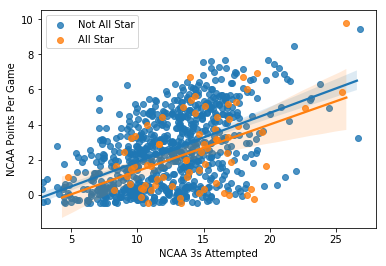

In [41]:
def Ncaa(df, name):
    return df[name]


"NCAA_ft",	"NCAA_ftapg"
ax = sns.regplot(x=Ncaa(college[college["All_Star"] ==0], "NCAA_ppg"), 
                 y=Ncaa(college[college["All_Star"] ==0], 'NCAA__3ptapg'),
                 x_jitter=0.5, y_jitter=0.5, label = "Not All Star")
ax = sns.regplot(x=Ncaa(college[college["All_Star"] ==1], "NCAA_ppg"), 
                 y=Ncaa(college[college["All_Star"] ==1], 'NCAA__3ptapg'),
                 x_jitter=0.5, y_jitter=0.5, label = "All Star")
plt.ylabel('NCAA Points Per Game')
plt.xlabel('NCAA 3s Attempted')
ax.legend()

The above table displays false positive, players who were predicted to be all stars but never did. The first 2 players on the list, Dearon Fox and Jamal Murray, are considered probable All stars in the future but are only 2-3 years into their playing careers.

In [43]:
fig = ff.create_annotated_heatmap(z=mat_d,
                                  x=["False", "True"], y=["False", "True"], 
                                  showscale=True)
fig.update_layout(font=dict(size=18))
# Add Labels
fig.add_annotation(x=0,y=0, text="True Negative", 
                   yshift=40, showarrow=False, font=dict(color="black",size=24))
fig.add_annotation(x=1,y=0, text="False Positive", 
                   yshift=40, showarrow=False, font=dict(color="white",size=24))
fig.add_annotation(x=0,y=1, text="False Negative", 
                   yshift=40, showarrow=False, font=dict(color="white",size=24))
fig.add_annotation(x=1,y=1, text="True Positive", 
                   yshift=40, showarrow=False, font=dict(color="white",size=24))

fig.update_xaxes(title="Predicted")
fig.update_yaxes(title="Actual", autorange="reversed")
fig

## NBA Game Results
#### Predicting NBA game scores with individual player metrics.
We had a lot more data available to us, and wanted to explore it, so we added another component to our project where we looked at whether we could predict NBA wins, and which features were most important for accurate predictions. Of course, these predictions were done without information about points from either side. Our idea here was that we could get an idea of which skills were most important in the game situation, and therefore players and teams should focus on honing.

In [45]:
box_scores = pd.read_csv("2012-18_officialBoxScore.csv", sep = ',',header = 0)
box_scores   

,gmDate,gmTime,seasTyp,offLNm,offFNm,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,...,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,WAS,East,Southeast,Away,Loss,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Smith,Michael,WAS,East,Southeast,Away,Loss,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
2,2012-10-30,19:00,Regular,Workman,Haywoode,WAS,East,Southeast,Away,Loss,...,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
3,2012-10-30,19:00,Regular,Brothers,Tony,CLE,East,Central,Home,Win,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
4,2012-10-30,19:00,Regular,Smith,Michael,CLE,East,Central,Home,Win,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
5,2012-10-30,19:00,Regular,Workman,Haywoode,CLE,East,Central,Home,Win,...,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
6,2012-10-30,20:00,Regular,McCutchen,Monty,BOS,East,Atlantic,Away,Loss,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
7,2012-10-30,20:00,Regular,Wright,Sean,BOS,East,Atlantic,Away,Loss,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
8,2012-10-30,20:00,Regular,Fitzgerald,Kane,BOS,East,Atlantic,Away,Loss,...,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
9,2012-10-30,20:00,Regular,McCutchen,Monty,MIA,East,Southeast,Home,Win,...,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832


In [50]:
def repopulate(df):
	columns = df.columns
	newdata=[]
	for index, row in df.iterrows():
		curData=[]
		teamData = []
		for column in columns:
			if column=='teamRslt':
				if row[column]=='Win':
					curData.append('Loss')
				else:
					curData.append('Win')
			else:
				if 'team' in column:
					teamData.append(row[column])
				else:
					curData.append(row[column])
		correctData= curData + teamData
		newdata.append(correctData)
	newdf= pd.DataFrame(data=newdata, columns = columns)
	frames = [df, newdf]
	result = pd.concat(frames,ignore_index=True)
	return result

In [52]:
def curateData():
    curatedData=[]
    prevdate = any
    prevtime = any
    prevpace = any

    for index, row in box_scores.iterrows():
        if index ==0:
            prevpace = row['pace']
            prevdate = row['gmDate']
            prevtime = row['gmTime']
        else:
            if row['pace']==prevpace and row['gmDate']==prevdate and row['gmTime']==prevtime and index%5==0:
                curatedData.append(row)
            else:
                prevpace = row['pace']
                prevdate = row['gmDate']
                prevtime = row['gmTime']

    realdf = pd.DataFrame(data=curatedData, columns = box_scores.columns)

    realdf = realdf.drop(['gmDate', 'gmTime', 'seasTyp', 'offLNm', 'offFNm', 'teamAbbr','teamConf','teamDiv', 'teamLoc', 'teamMin', 'teamPTS', 'teamPTS1','teamPTS2','teamPTS3', 'teamPTS4', 'teamPTS5', 'teamPTS6', 'teamPTS7', 'teamPTS8','teamTREB%', 'teamASST%', 'teamTS%', 'teamEFG%', 'teamOREB%', 'teamDREB%', 'teamTO%', 'teamSTL%', 'teamBLK%', 'teamBLKR','teamPPS', 'teamFIC', 'teamFIC40', 'teamOrtg', 'teamDrtg', 'teamEDiff','teamPlay%', 'teamAR', 'teamAST/TO', 'teamSTL/TO', 'opptAbbr', 'opptConf', 'opptDiv', 'opptLoc', 'opptRslt', 'opptMin', 'opptPTS','opptPTS1','opptPTS2','opptPTS3', 'opptPTS4', 'opptPTS5', 'opptPTS6', 'opptPTS7', 'opptPTS8','opptTREB%', 'opptASST%', 'opptTS%','opptEFG%', 'opptOREB%', 'opptDREB%', 'opptTO%', 'opptSTL%', 'opptBLK%', 'opptBLKR', 'opptPPS','opptFIC', 'opptFIC40', 'opptOrtg', 'opptDrtg', 'opptEDiff', 'opptPlay%','opptAR', 'opptAST/TO', 'opptSTL/TO', 'poss','pace'], axis=1)
    return realdf
curate= curateData()
repopulate(curate)

,teamRslt,teamDayOff,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,...,oppt2P%,oppt3PA,oppt3PM,oppt3P%,opptFTA,opptFTM,opptFT%,opptORB,opptDRB,opptTRB
0,Win,0,22,21,7,5,21,79,36,0.4557,...,0.4138,32,8,0.2500,20,12,0.6000,18,21,39
1,Win,0,25,8,8,5,20,79,43,0.5443,...,0.5323,13,6,0.4615,28,23,0.8214,7,34,41
2,Loss,0,24,14,6,5,21,77,38,0.4935,...,0.5000,15,5,0.3333,18,14,0.7778,9,31,40
3,Loss,0,19,22,9,5,22,88,33,0.3750,...,0.3833,25,7,0.2800,21,17,0.8095,14,33,47
4,Win,0,22,19,3,10,16,78,37,0.4744,...,0.3649,17,6,0.3529,19,16,0.8421,15,27,42
5,Loss,0,21,16,12,4,15,79,35,0.4430,...,0.5577,27,10,0.3704,23,17,0.7391,12,33,45
6,Win,0,21,18,8,10,19,79,33,0.4177,...,0.4179,17,6,0.3529,16,13,0.8125,11,29,40
7,Loss,0,26,15,7,6,20,80,35,0.4375,...,0.5333,20,6,0.3000,26,17,0.6538,10,33,43
8,Loss,1,20,16,8,5,32,85,32,0.3765,...,0.4267,14,6,0.4286,42,31,0.7381,20,41,61
9,Win,0,19,18,9,3,20,86,33,0.3837,...,0.4746,21,4,0.1905,22,17,0.7727,11,33,44


In [53]:
def train_model():
    fulldf = repopulate(curateData())
    fulldf['teamRslt'] = fulldf['teamRslt'].apply(lambda x: 0 if x=='Win' else 1)

    labels = np.array(fulldf['teamRslt'])
    fulldf= fulldf.drop('teamRslt', axis = 1)
    feature_list = list(fulldf.columns)
    features = np.array(fulldf)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)

    rf = ensemble.RandomForestClassifier(n_estimators = 100, random_state = 42)
    rf.fit(train_features, train_labels)
    print("Train Accuracy: ", rf.score(train_features, train_labels))
    print("Test Accuracy: ", rf.score(test_features, test_labels))
    importances = list(rf.feature_importances_)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    for pair in feature_importances:
         print('Variable:' + str(pair[0]) + '  Importance:' + str(pair[1]))

Below are all the features considered by the Random Forest Classifier, ordered by their importance (weights) in the algorithm. 

In [54]:
train_model()

Training Features Shape: (10573, 42)
Training Labels Shape: (10573,)
Testing Features Shape: (3525, 42)
Testing Labels Shape: (3525,)
Train Accuracy:  1.0
Test Accuracy:  0.9063829787234042
Variable:teamFG%  Importance:0.11
Variable:opptFG%  Importance:0.11
Variable:teamFGM  Importance:0.06
Variable:opptFGM  Importance:0.06
Variable:oppt3P%  Importance:0.04
Variable:team2P%  Importance:0.03
Variable:team3P%  Importance:0.03
Variable:teamFTM  Importance:0.03
Variable:teamDRB  Importance:0.03
Variable:opptAST  Importance:0.03
Variable:oppt2P%  Importance:0.03
Variable:opptFTM  Importance:0.03
Variable:opptDRB  Importance:0.03
Variable:teamAST  Importance:0.02
Variable:teamTO  Importance:0.02
Variable:teamPF  Importance:0.02
Variable:team3PM  Importance:0.02
Variable:teamFTA  Importance:0.02
Variable:teamTRB  Importance:0.02
Variable:opptTO  Importance:0.02
Variable:opptPF  Importance:0.02
Variable:oppt3PM  Importance:0.02
Variable:opptFTA  Importance:0.02
Variable:opptTRB  Importance:0.0